In [1]:
import seaborn as sns
import statsmodels.tsa.stattools as ts 
import statsmodels.api as sm
from numpy import log, polyfit, sqrt, std, subtract
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.relativedelta import *

from scipy import stats

import pyfolio as pf

import ffn

from backtester import backtest as bt
from backtester import backtest_with_cost as btwc

%matplotlib inline

In [2]:
def annual_return(returns):
    return (1+returns.pct_change().mean())**(len(returns)/19)-1

def cagr(returns):
    #return (returns.iloc[-1])**(12/(19*12))-1

    return (returns.iloc[-1])**(1/19)-1

def total_return(returns):
    return (returns.iloc[-1]-1)

def standard_deviation(returns):
    return returns.pct_change().std()*np.sqrt(252)

def mdd(returns):
    maximums = np.maximum.accumulate(returns)
    drawdowns = 1 - returns / maximums
    return np.max(drawdowns)

def downside_risk(returns, required_return=0):
    downside_diff = returns - required_return
    mask = downside_diff > 0
    downside_diff[mask] = 0.0
    squares = np.square(downside_diff)
    mean_squares = np.nanmean(squares, axis=0)
    return np.sqrt(mean_squares)

def sortino_ratio(returns, required_return=0):
    mu = np.nanmean(returns - required_return, axis=0)
    return mu / downside_risk(returns, required_return)

def sr(returns):
    ret = returns.pct_change()
    
    rf = (1.019)**(1/360) - 1
    TDD = np.sqrt(-np.where((ret-rf) < 0.0, (ret-rf), 0).mean())
    eff_ret = ret.mean() - rf

    return eff_ret/TDD

def ttest(returns):
    ret = returns.pct_change()
    ret[0] = 0.0
    tstat, pval = stats.ttest_1samp(ret.to_numpy(), 0.0)
    return tstat, pval

In [3]:
ind = pd.read_csv('C:/Users/jango/code/research_env/BTHE/results_ind.csv',index_col='DATE', parse_dates=True)
fin = pd.read_csv('C:/Users/jango/code/research_env/BTHE/results_fin.csv',index_col='DATE', parse_dates=True)
cg = pd.read_csv('C:/Users/jango/code/research_env/BTHE/results_cg.csv',index_col='DATE', parse_dates=True)
hc = pd.read_csv('C:/Users/jango/code/research_env/BTHE/results_hc.csv',index_col='DATE', parse_dates=True)
all_ = pd.read_csv('C:/Users/jango/code/research_env/BTHE/results_all.csv',index_col='DATE', parse_dates=True)

In [22]:

ind = pd.read_csv('C:/Users/jango/code/research_env/BTHE/results_volume_ind.csv',index_col='DATE', parse_dates=True)
fin = pd.read_csv('C:/Users/jango/code/research_env/BTHE/results_volume_fin.csv',index_col='DATE', parse_dates=True)
cg = pd.read_csv('C:/Users/jango/code/research_env/BTHE/results_volume_cg.csv',index_col='DATE', parse_dates=True)
hc = pd.read_csv('C:/Users/jango/code/research_env/BTHE/results_volume_hc.csv',index_col='DATE', parse_dates=True)
all_ = pd.read_csv('C:/Users/jango/code/research_env/BTHE/results_volume_all.csv',index_col='DATE', parse_dates=True)


benchmark = pd.read_csv('C:/Users/jango/code/research_env/BTHE/Datalink/csv/SPI.csv',index_col='DATE', parse_dates=True).ffill()

"""ind = pd.read_csv('C:/Users/jango/code/research_env/BTHE/results_ind_wc.csv',index_col='DATE', parse_dates=True)
fin = pd.read_csv('C:/Users/jango/code/research_env/BTHE/results_fin_wc.csv',index_col='DATE', parse_dates=True)
cg = pd.read_csv('C:/Users/jango/code/research_env/BTHE/results_cg_wc.csv',index_col='DATE', parse_dates=True)
hc = pd.read_csv('C:/Users/jango/code/research_env/BTHE/results_hc_wc.csv',index_col='DATE', parse_dates=True)"""

"ind = pd.read_csv('C:/Users/jango/code/research_env/BTHE/results_ind_wc.csv',index_col='DATE', parse_dates=True)\nfin = pd.read_csv('C:/Users/jango/code/research_env/BTHE/results_fin_wc.csv',index_col='DATE', parse_dates=True)\ncg = pd.read_csv('C:/Users/jango/code/research_env/BTHE/results_cg_wc.csv',index_col='DATE', parse_dates=True)\nhc = pd.read_csv('C:/Users/jango/code/research_env/BTHE/results_hc_wc.csv',index_col='DATE', parse_dates=True)"

In [387]:
master_cum = (1+pd.read_csv('C:/Users/jango/code/research_env/BTHE/results_selection.csv',index_col='DATE', parse_dates=True)['2013':].pct_change()).cumprod()

In [25]:
amounts = [2, 5, 10]
n = [0.5, 1.0 , 1.5, 2.0]
sectors = ['hc', 'cg', 'fin', 'ind', 'all']

In [27]:
mama = master_cum.copy()

In [28]:
master_cum = {}

master_cum['hc'] = hc['10ssd0.5std']
master_cum['cg'] = cg['10ssd0.5std']
master_cum['fin'] = fin['10ssd0.5std']
master_cum['ind'] = ind['10ssd0.5std']
master_cum['total'] = mama['10ssd0.5std']

In [26]:
master_cum = {}


for number in n:
    for amount in amounts:
        temp = {}
        name = '{}ssd{}std'.format(amount, number)
        temp['ind'] = ind[name]
        temp['fin'] = fin[name]
        temp['cg'] = cg[name]
        temp['hc'] = hc[name]
        master_cum[name] = pd.DataFrame(temp).mean(axis=1)
        
#master_cum['bm'] = benchmark.Close

In [13]:
cum_ret = pd.DataFrame(master_cum)
perf = cum_ret.calc_stats()
perf.set_riskfree_rate(0.019)
perf.display()

Stat                 2ssd0.5std    5ssd0.5std    10ssd0.5std    2ssd1.0std    5ssd1.0std    10ssd1.0std    2ssd1.5std    5ssd1.5std    10ssd1.5std    2ssd2.0std    5ssd2.0std    10ssd2.0std
-------------------  ------------  ------------  -------------  ------------  ------------  -------------  ------------  ------------  -------------  ------------  ------------  -------------
Start                2001-01-03    2001-01-03    2001-01-03     2001-01-03    2001-01-03    2001-01-03     2001-01-03    2001-01-03    2001-01-03     2001-01-03    2001-01-03    2001-01-03
End                  2019-12-30    2019-12-30    2019-12-30     2019-12-30    2019-12-30    2019-12-30     2019-12-30    2019-12-30    2019-12-30     2019-12-30    2019-12-30    2019-12-30
Risk-free rate       1.90%         1.90%         1.90%          1.90%         1.90%         1.90%          1.90%         1.90%         1.90%          1.90%         1.90%         1.90%

Total Return         12.58%        67.54%        75.10%

In [226]:
annualized_return(master_cum['2ssd0.5std'].pct_change())

-0.020049844171713405

In [5]:
master_cum = all_

In [6]:
measurements = {}

for n in master_cum:
    measurements[n] = {}
    measurements[n]['annual_return'] = cagr(master_cum[n])*100
    measurements[n]['total_return'] = total_return(master_cum[n])
    measurements[n]['annual_volatility'] = standard_deviation(master_cum[n])*100
    measurements[n]['mdd'] = mdd(master_cum[n])*-100
    measurements[n]['sr'] = sr(master_cum[n])*100
    measurements[n]['tstat'], measurements[n]['pvalue'] = ttest(master_cum[n])

In [7]:
pd.DataFrame(measurements)

,2ssd0.5std,5ssd0.5std,10ssd0.5std,2ssd1.0std,5ssd1.0std,10ssd1.0std,2ssd1.5std,5ssd1.5std,10ssd1.5std,2ssd2.0std,5ssd2.0std,10ssd2.0std
annual_return,-2.511967,-1.090322,-0.161202,0.047014,0.759109,-0.286122,-1.365734,-0.266449,-0.411084,1.002194,0.434498,-0.348087
annual_volatility,10.557581,5.966262,5.583823,7.461751,5.266339,4.651724,6.677437,5.065143,5.174876,5.725606,4.801086,4.577764
mdd,-47.716623,-27.575107,-17.416356,-32.022681,-10.557689,-19.363279,-44.463526,-22.262557,-15.140500,-19.429051,-10.742859,-13.120560
pvalue,0.434028,0.505134,0.999016,0.848841,0.459254,0.867630,0.452865,0.905347,0.814806,0.377231,0.618608,0.817051
sr,-0.357186,-0.269895,-0.171883,-0.110283,-0.051997,-0.185800,-0.292293,-0.184696,-0.200135,-0.021205,-0.102250,-0.204712
total_return,-0.383299,-0.188036,-0.030188,0.008971,0.154522,-0.052986,-0.229933,-0.049430,-0.075283,0.208608,0.085864,-0.064105
tstat,-0.782384,-0.666483,-0.001234,0.190608,0.740136,-0.166679,-0.750708,-0.118916,-0.234244,0.883092,0.497856,-0.231352


In [342]:
df_ret = pd.DataFrame(master_cum['bm'].pct_change()).Close

In [345]:
downside_returns = df_ret.loc[df_ret < 0.0]
expected_return = df_ret.mean()
down_stdev = downside_returns.std()

In [347]:
expected_return

0.00023407787801663028

In [354]:
ret = master_cum['bm'].pct_change()
rf = (1.019)**(1/360) - 1
TDD = np.sqrt(-np.where((ret-rf) < 0.0, (ret-rf), 0).mean())
eff_ret = ret.mean() - rf

eff_ret/TDD

0.0029975464152207296

In [350]:
ret = master_cum['bm'].pct_change()
rf = (1.019)**(1/360) - 1
TDD = np.sqrt(-np.where((ret-rf) < 0.0, (ret-rf), 0).mean())
eff_ret = ret.mean() - rf

eff_ret/TDD

0.0029975464152207296

In [353]:
eff_ret / standard_deviation(master_cum[n])

0.0010432462923254042

In [19]:
(expected_return - 0.019)/down_stdev

-11.915618957666023

In [180]:
downside_returns = df_ret.loc[df_ret[0] < 0.0]
expected_return = df_ret[0].mean()
down_stdev = downside_returns[0].std()

In [182]:
expected_return

0.0001195492301381833

In [176]:
downside_returns

,0
DATE,


In [ ]:
return (expected_return - 0.019)/down_stdev

In [92]:
len(master_cum['10ssd0.5std'])

252.57894736842104

In [45]:
daily_avg = master_cum['10ssd0.5std'].pct_change().mean()
yearly_avg = daily_avg*252.57894736842104

In [59]:
total_return(annual_return(master_cum['10ssd0.5std']))

0.7598444076329234

In [49]:
carg = (daily_avg+1)**252-1

In [50]:
carg ** 19

1.751170844758512e-29

In [29]:
yearly_avg*19

0.5724017139016216

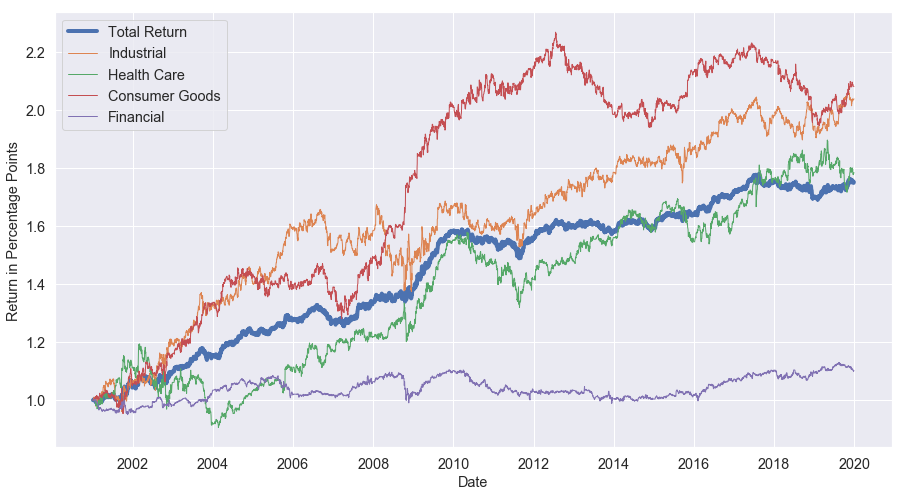

In [44]:
sns.set(rc={'figure.figsize':(15,8)})
fig, ax = plt.subplots()

good = ax.plot(master_cum['total'], label='Total Return', lw='4')
good = ax.plot(master_cum['ind'], label='Industrial', lw='1')
good = ax.plot(master_cum['hc'], label='Health Care', lw='1')
good = ax.plot(master_cum['cg'], label='Consumer Goods', lw='1')
good = ax.plot(master_cum['fin'], label='Financial', lw='1')
good = ax.legend(loc=2, fontsize="large")
good = ax.set_ylabel("Return in Percentage Points", fontsize="large")
good = ax.set_xlabel("Date", fontsize="large")
good = ax.tick_params(labelsize='large')

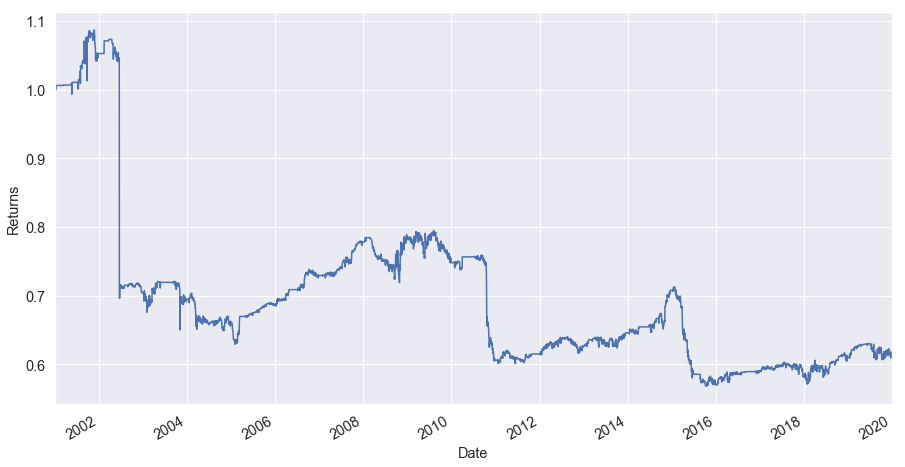

In [13]:
sns.set(rc={'figure.figsize':(15,8)})
fig, ax = plt.subplots()
bad = master_cum['2ssd0.5std'].plot()
bad = plt.ylabel("Returns", fontsize="large")
bad = plt.xlabel("Date", fontsize="large")
bad = ax.tick_params(labelsize='large')

Start date,2001-01-03
End date,2019-12-30
Total months,228
,Backtest
Annual return,3.0%
Cumulative returns,75.1%
Annual volatility,3.7%
Sharpe ratio,0.80
Calmar ratio,0.47
Stability,0.93
Max drawdown,-6.3%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,6.30,2010-03-19,2011-08-23,2012-03-01,510
1,5.51,2006-08-08,2007-04-10,2007-08-22,272
2,5.03,2017-08-18,2019-02-01,NaT,NaN
3,3.86,2002-04-29,2002-07-25,2002-09-03,92
4,3.50,2003-09-25,2003-11-07,2004-03-30,134


C:\Users\jango\Anaconda3\envs\research\lib\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


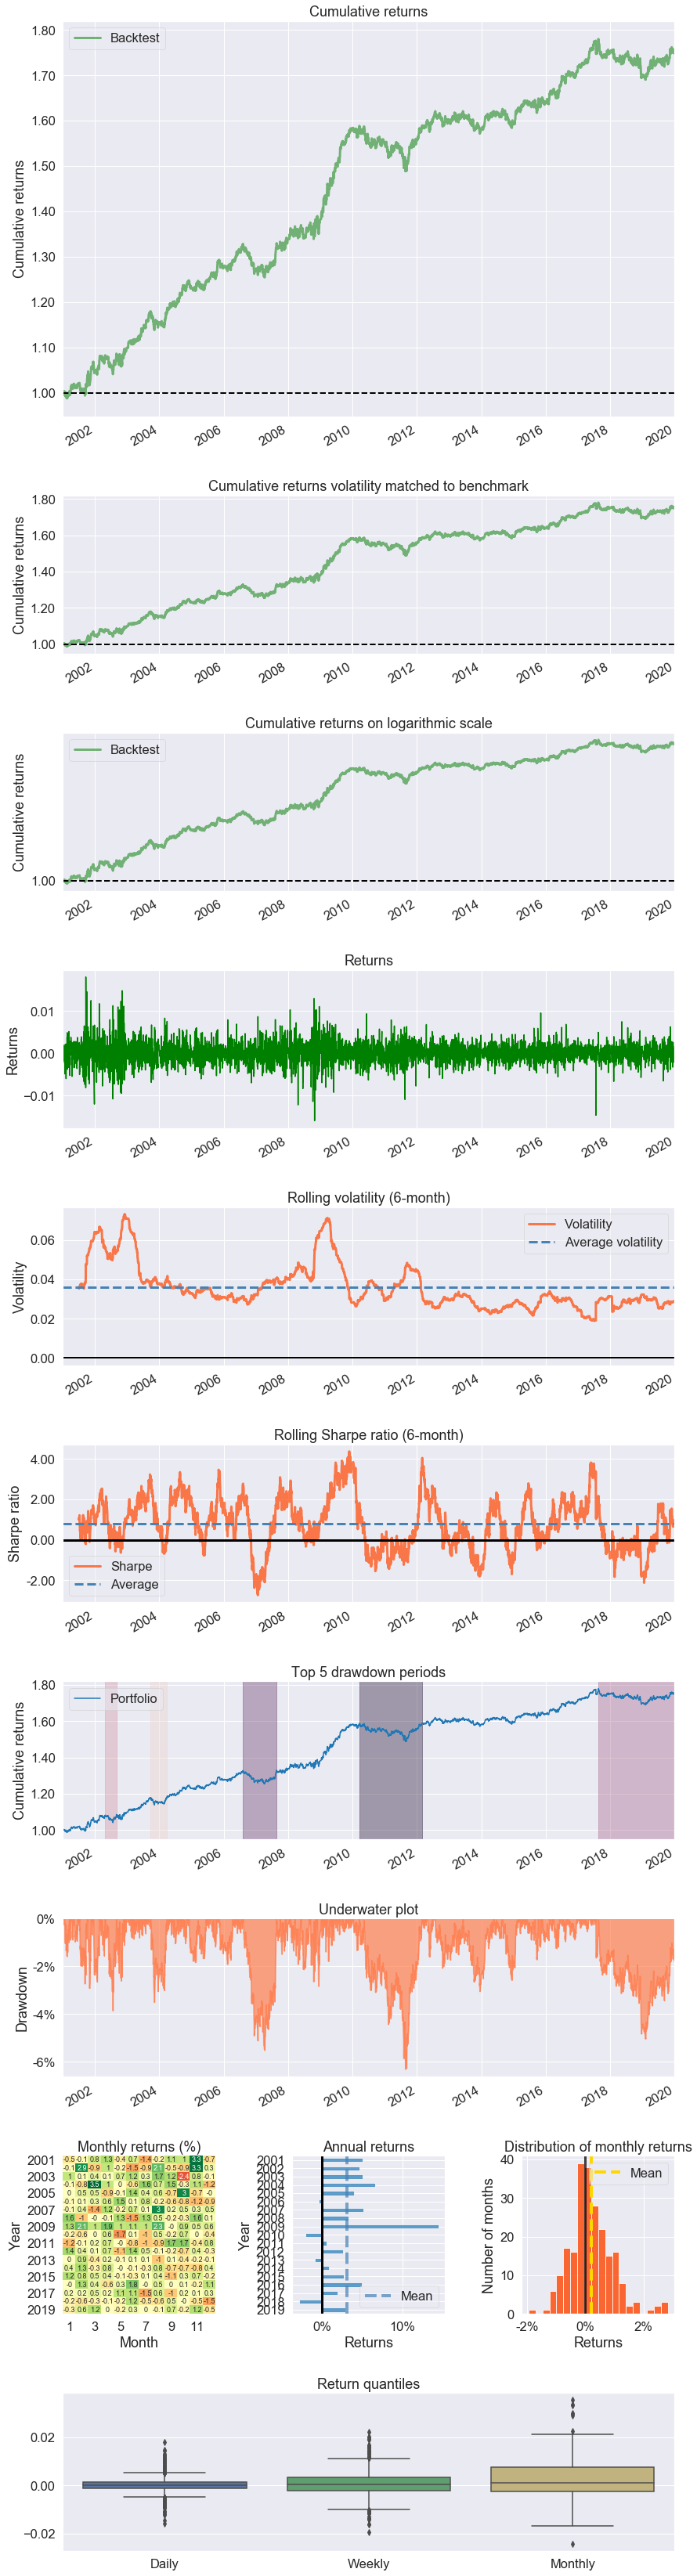

ValueError: cannot reindex from a duplicate axis

In [13]:
pf.create_full_tear_sheet(master_cum['10ssd0.5std'].pct_change(), benchmark_rets=None)

In [73]:
ret = all_['10ssd0.5std'].pct_change()
ret[0] = 0.0
tstat, pval = stats.ttest_1samp(ret.to_numpy(), 0.0)

In [74]:
print(tstat)
print(pval / 2) 

-0.028201857290615685
0.4887511644025165


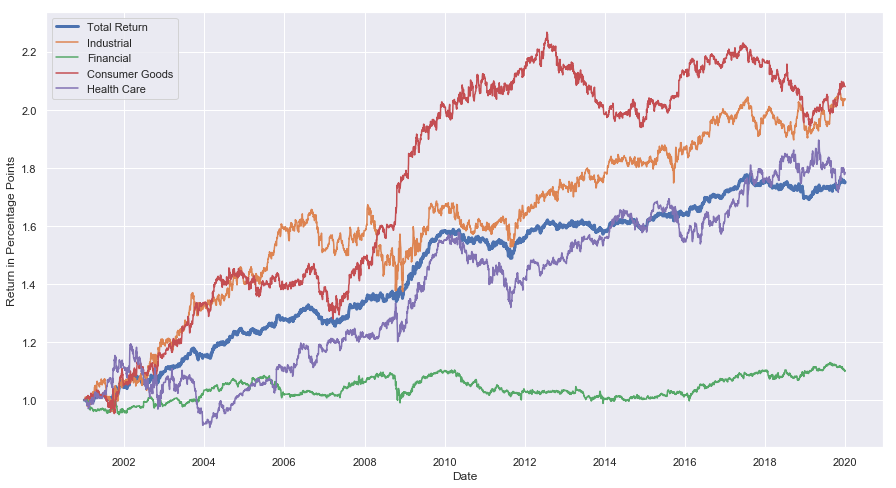

In [19]:
sns.set(rc={'figure.figsize':(15,8)})
ploot = plt.plot(cum_ret['10ssd0.5std'], label='Total Return', lw=3)
ploot = plt.plot(ind['10ssd0.5std'], label='Industrial')
ploot = plt.plot(fin['10ssd0.5std'], label='Financial')
ploot = plt.plot(cg['10ssd0.5std'], label='Consumer Goods')
ploot = plt.plot(hc['10ssd0.5std'],  label='Health Care')
#ploot = plt.plot(benchmark, label='Benchmark')
c1 = plt.legend()
c1 = plt.xlabel("Date")
c1 = plt.ylabel("Return in Percentage Points")

In [20]:
c1.figure.savefig("sector_results.png")

In [22]:
comparison = {}

comparison['total'] = cum_ret['10ssd0.5std']
comparison['Industrial'] = ind['10ssd0.5std']
comparison['Finance'] = fin['10ssd0.5std']
comparison['Consumer Goods'] = cg['10ssd0.5std']
comparison['Health Care'] = hc['10ssd0.5std']

In [23]:
comparison_df = pd.DataFrame(comparison)
comparison_df['SPI'] = benchmark.Close

In [24]:
comp = comparison_df.calc_stats()
comp.set_riskfree_rate(0.019)
comp.display()

Stat                 total       Industrial    Finance     Consumer Goods    Health Care    SPI
-------------------  ----------  ------------  ----------  ----------------  -------------  ----------
Start                2001-01-03  2001-01-03    2001-01-03  2001-01-03        2001-01-03     2001-01-03
End                  2019-12-30  2019-12-30    2019-12-30  2019-12-30        2019-12-30     2019-12-30
Risk-free rate       1.90%       1.90%         1.90%       1.90%             1.90%          1.90%

Total Return         75.10%      103.79%       10.23%      107.97%           78.42%         129.17%
Daily Sharpe         0.31        0.27          -0.30       0.31              0.18           0.23
Daily Sortino        0.53        0.45          -0.49       0.54              0.30           0.36
CAGR                 2.99%       3.82%         0.51%       3.93%             3.10%          4.46%
Max Drawdown         -6.30%      -17.88%       -10.48%     -14.47%           -24.11%        -53.54%
Calm

In [93]:
comparison_df.corr()

,total,Industrial,Finance,Consumer Goods,Health Care,SPI
total,1.000000,0.953073,-0.437882,0.968622,0.947235,0.784422
Industrial,0.953073,1.000000,-0.405646,0.870527,0.884214,0.856136
Finance,-0.437882,-0.405646,1.000000,-0.411057,-0.580231,-0.546725
Consumer Goods,0.968622,0.870527,-0.411057,1.000000,0.878901,0.631069
Health Care,0.947235,0.884214,-0.580231,0.878901,1.000000,0.854083
SPI,0.784422,0.856136,-0.546725,0.631069,0.854083,1.000000


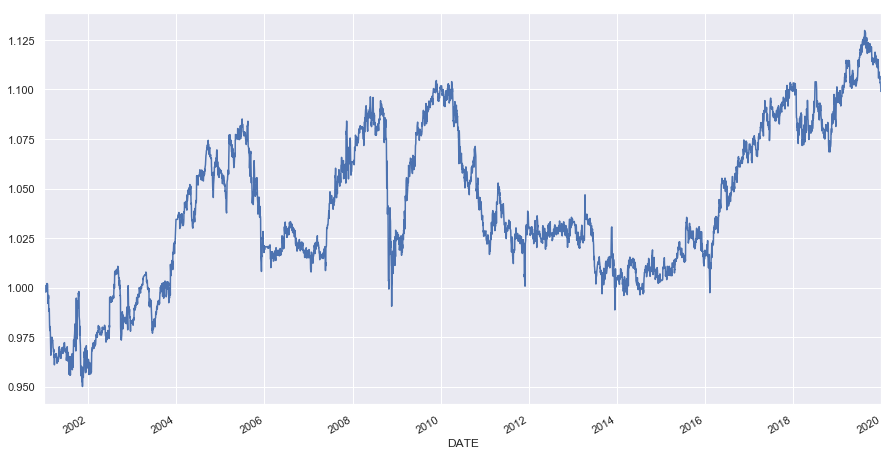

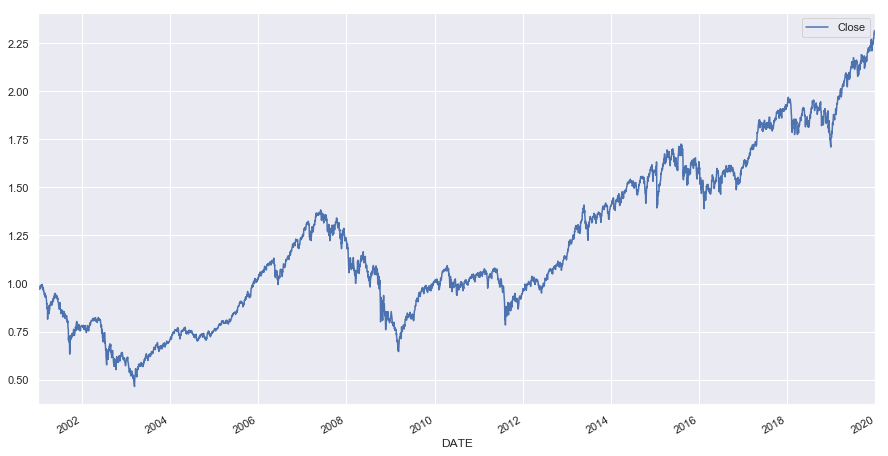

In [26]:
fin['10ssd0.5std'].plot()
benchmark.plot()

In [7]:
ret = cum_ret['10ssd0.5std'].pct_change()
ret[0] = 0.0

In [8]:
stats.ttest_1samp(ret.to_numpy(), 0.0)

Ttest_1sampResult(statistic=3.5081865902172513, pvalue=0.0004553100825786854)

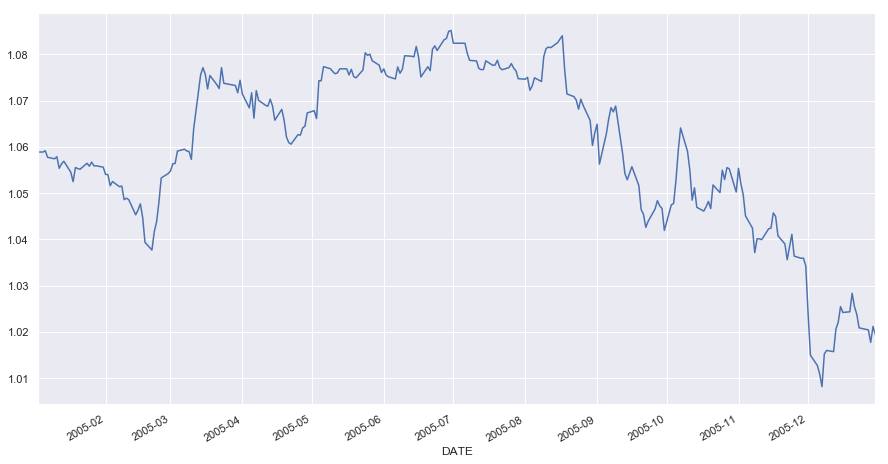

In [27]:
fin['10ssd0.5std']['2005'].plot()

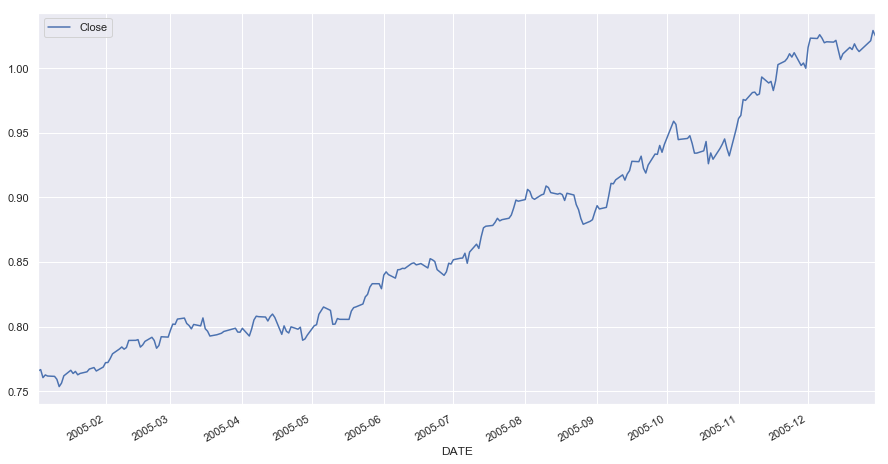

In [28]:
benchmark['2005'].plot()

In [34]:
benchmark['2005'].pct_change().describe()

,Close
count,254.000000
mean,0.001165
std,0.005593
min,-0.018248
25%,-0.002288
50%,0.001239
75%,0.004434
max,0.022367
